In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

import ncar_jobqueue
from dask.distributed import Client

#### Get mean ALK over the last IAF cycle for 003 run

In [2]:
variables = ['ALK_ALT_CO2','ALK'] 

In [3]:
#write out annual means
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
path = '/glade/scratch/mclong/besome/cesm_cases/' + case + '/sigma_coord/'
infile = path + 'cesm22cocco.G1850ECOIAF.T62_g17.003.pop.h.sigma.ALK.024901-031012.nc'
infile2 = path + 'cesm22cocco.G1850ECOIAF.T62_g17.003.pop.h.sigma.ALK_ALT_CO2.024901-031012.nc'

In [4]:
%%time
ds_list = []
print(f'reading {case}')
ds_alk_alt = xr.Dataset()

v = 'ALK_ALT_CO2'
    
file = sorted(glob(f'{path}/{case}.pop.h.sigma.{v}.024901-031012.nc'))       
#print(file)   
ds_alk_alt = xr.open_mfdataset(file, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'sigma' : 1})

reading cesm22cocco.G1850ECOIAF.T62_g17.003
CPU times: user 59.9 ms, sys: 17.4 ms, total: 77.2 ms
Wall time: 644 ms


In [5]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['sigma','time_bound','TAREA','REGION_MASK','ALK_ALT_CO2','THICKNESS']
keep_vars = keepthese +list(coords.values())   #+['dz','KMT']
ds_alk_alt = ds_alk_alt.drop([v for v in ds_alk_alt.variables if v not in keep_vars])
#ds_alk_alt

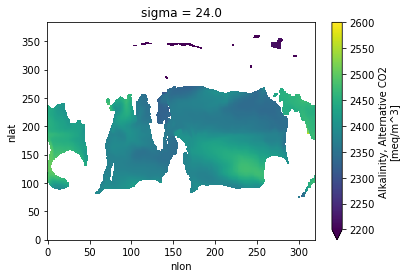

In [6]:
ds_alk_alt.ALK_ALT_CO2.isel(time=0,sigma=0).where(ds_alk_alt.ALK_ALT_CO2.isel(time=0,sigma=0)<10000.).plot(vmin=2200,vmax=2600)

In [7]:
%%time
ds_list = []
print(f'reading {case}')
ds_alk = xr.Dataset()

v = 'ALK'
    
file = sorted(glob(f'{path}/{case}.pop.h.sigma.{v}.024901-031012.nc'))       
    
ds_alk = xr.open_mfdataset(file, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'sigma' : 1})

reading cesm22cocco.G1850ECOIAF.T62_g17.003
CPU times: user 54.3 ms, sys: 2.44 ms, total: 56.7 ms
Wall time: 190 ms


In [8]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['sigma','time_bound','TAREA','REGION_MASK','ALK','THICKNESS']
keep_vars = keepthese +list(coords.values())   #+['dz','KMT']
ds_alk = ds_alk.drop([v for v in ds_alk.variables if v not in keep_vars])
#ds_alk

In [9]:
#ds_alk

### and for the 2x run

In [10]:
#write out annual means
case = 'cesm22cocco.G1850ECOIAF.T62_g17.004'
path = '/glade/scratch/kristenk/besome/cesm_cases/' + case + '/sigma_coord/'
infile = path + 'cesm22cocco.G1850ECOIAF.T62_g17.004.pop.h.sigma.ALK.024901-031012.nc'
infile2 = path + 'cesm22cocco.G1850ECOIAF.T62_g17.004.pop.h.sigma.ALK_ALT_CO2.024901-031012.nc'

In [11]:
%%time
ds_list = []
print(f'reading {case}')
ds_alk_alt2x = xr.Dataset()

v = 'ALK_ALT_CO2'
    
file = sorted(glob(f'{path}/{case}.pop.h.sigma.{v}.024901-031012.nc'))       
#print(file)   
ds_alk_alt2x = xr.open_mfdataset(file, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'sigma' : 1})

reading cesm22cocco.G1850ECOIAF.T62_g17.004
CPU times: user 51.3 ms, sys: 5.3 ms, total: 56.6 ms
Wall time: 260 ms


In [12]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['sigma','time_bound','TAREA','REGION_MASK','ALK_ALT_CO2','THICKNESS']
keep_vars = keepthese +list(coords.values())   #+['dz','KMT']
ds_alk_alt2x = ds_alk_alt2x.drop([v for v in ds_alk_alt2x.variables if v not in keep_vars])
#ds_alk_alt2x

In [14]:
%%time
ds_list = []
print(f'reading {case}')
ds_alk2x = xr.Dataset()

v = 'ALK'
    
file = sorted(glob(f'{path}/{case}.pop.h.sigma.{v}.024901-031012.nc'))       
    
ds_alk2x = xr.open_mfdataset(file, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'sigma' : 1})

reading cesm22cocco.G1850ECOIAF.T62_g17.004
CPU times: user 53.6 ms, sys: 2.73 ms, total: 56.3 ms
Wall time: 158 ms


In [15]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['sigma','time_bound','TAREA','REGION_MASK','ALK','THICKNESS']
keep_vars = keepthese +list(coords.values())   #+['dz','KMT']
ds_alk2x = ds_alk2x.drop([v for v in ds_alk2x.variables if v not in keep_vars])
#ds_alk

### other setup

In [16]:
cluster = ncar_jobqueue.NCARCluster(project='ncgd0011')
cluster.adapt(minimum_jobs=0, maximum_jobs=30)
client = Client(cluster)
client

Client Scheduler: tcp://128.117.181.224:44377 Dashboard: https://jupyterhub.ucar.edu/dav/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [17]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
#ds_woa['z_t'] = cesm_ann_ds.z_t

In [18]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
area_m = area * 1.e-4
thickness_m = ds_alk_alt.THICKNESS * 0.01
sigmas = ds_alk_alt.sigma

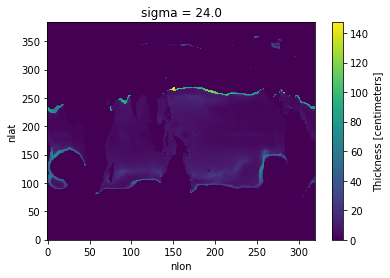

In [19]:
thickness_m.isel(sigma=0,time=0).plot()

### Let's look vertically with horizontal integration

#### noGCB global

In [20]:
alk_alt = ds_alk_alt.ALK_ALT_CO2.where(ds_alk_alt.ALK_ALT_CO2<10000.)
alk_alt = alk_alt * thickness_m * 0.001 #convert to mol/m2

alk = ds_alk.ALK.where(ds_alk.ALK<10000.)
alk = alk * thickness_m * 0.001 #convert to mol/m2

In [21]:
%%time
Alk_glb_horiz_int = xr.Dataset({v: ds_alk[v] for v in ['sigma','time']})
#units are mols of alk
Alk_glb_horiz_int['ALK'] = esmlab.weighted_sum(alk, weights=area_m, dim=['nlon','nlat']).compute()

CPU times: user 4.81 s, sys: 1.39 s, total: 6.21 s
Wall time: 3min 16s


In [22]:
%%time
Alk_glb_horiz_int['ALK_ALT_CO2'] = esmlab.weighted_sum(alk_alt, weights=area_m, dim=['nlon','nlat']).compute()

CPU times: user 3.15 s, sys: 933 ms, total: 4.09 s
Wall time: 1min 53s


In [23]:
Alk_glb_horiz_int_mean = Alk_glb_horiz_int.mean(dim='time') #units are mols of alk

In [24]:
Alk_glb_horiz_int_mean

<xarray.Dataset>
Dimensions:      (sigma: 22)
Coordinates:
  * sigma        (sigma) float64 24.0 24.2 24.4 24.6 ... 27.6 27.8 28.0 28.2
Data variables:
    ALK          (sigma) float64 3.852e+15 4.177e+15 ... 2.925e+17 2.591e+15
    ALK_ALT_CO2  (sigma) float64 3.908e+15 4.239e+15 ... 2.933e+17 2.592e+15

In [25]:
alk_diff = Alk_glb_horiz_int_mean.ALK_ALT_CO2 - Alk_glb_horiz_int_mean.ALK

In [26]:
alk_diff = alk_diff * 1.e-12  # Tmol per sigma layer

#### noGCB SO

In [27]:
alk_alt = ds_alk_alt.ALK_ALT_CO2.where(ds_alk_alt.ALK_ALT_CO2<10000.).where(lats<-45)
alk_alt = alk_alt * thickness_m * 0.001 #convert to mol/m2

alk = ds_alk.ALK.where(ds_alk.ALK<10000.).where(lats<-45)
alk = alk * thickness_m * 0.001 #convert to mol/m2

In [28]:
%%time
Alk_SO_horiz_int = xr.Dataset({v: ds_alk[v] for v in ['sigma','time']})
#units are mols of alk
Alk_SO_horiz_int['ALK'] = esmlab.weighted_sum(alk, weights=area_m, dim=['nlon','nlat']).compute()

CPU times: user 6.74 s, sys: 1.46 s, total: 8.21 s
Wall time: 4min 27s


In [29]:
%%time
Alk_SO_horiz_int['ALK_ALT_CO2'] = esmlab.weighted_sum(alk_alt, weights=area_m, dim=['nlon','nlat']).compute()

CPU times: user 4.29 s, sys: 1.08 s, total: 5.38 s
Wall time: 2min 57s


In [30]:
Alk_SO_horiz_int_mean = Alk_SO_horiz_int.mean(dim='time') #units are mols of alk

In [31]:
alk_diff_so = Alk_SO_horiz_int_mean.ALK_ALT_CO2 - Alk_SO_horiz_int_mean.ALK

In [32]:
alk_diff_so = alk_diff_so * 1.e-12  # Tmol per sigma layer

In [33]:
thickness_m.time

<xarray.DataArray 'time' (time: 744)>
array([  0,   1,   2, ..., 741, 742, 743])
Dimensions without coordinates: time

In [34]:
alk_alt.time

<xarray.DataArray 'time' (time: 744)>
array([  0,   1,   2, ..., 741, 742, 743])
Dimensions without coordinates: time

### 2xGCB global

In [35]:
thickness_m = ds_alk_alt2x.THICKNESS * 0.01

In [37]:
alk_alt = ds_alk_alt2x.ALK_ALT_CO2.where(ds_alk_alt2x.ALK_ALT_CO2<10000.)
alk_alt = alk_alt * thickness_m * 0.001 #convert to mol/m2

alk = ds_alk2x.ALK.where(ds_alk2x.ALK<10000.)
alk = alk * thickness_m * 0.001 #convert to mol/m2

In [38]:
%%time
Alk_glb_horiz_int = xr.Dataset({v: ds_alk[v] for v in ['sigma','time']})
#units are mols of alk
Alk_glb_horiz_int['ALK'] = esmlab.weighted_sum(alk, weights=area_m, dim=['nlon','nlat']).compute()

CPU times: user 12 s, sys: 2.04 s, total: 14.1 s
Wall time: 4min 40s


In [39]:
%%time
Alk_glb_horiz_int['ALK_ALT_CO2'] = esmlab.weighted_sum(alk_alt, weights=area_m, dim=['nlon','nlat']).compute()

CPU times: user 6.35 s, sys: 1.45 s, total: 7.8 s
Wall time: 1min 58s


In [40]:
Alk_glb_horiz_int_mean = Alk_glb_horiz_int.mean(dim='time') #units are mols of alk

In [41]:
alk_diff2x = Alk_glb_horiz_int_mean.ALK_ALT_CO2 - Alk_glb_horiz_int_mean.ALK

In [42]:
alk_diff2x = alk_diff2x * 1.e-12  # Tmol per sigma layer

### 2xGCB SO

In [44]:
alk_alt = ds_alk_alt2x.ALK_ALT_CO2.where(ds_alk_alt2x.ALK_ALT_CO2<10000.).where(lats<-45)
alk_alt = alk_alt * thickness_m * 0.001 #convert to mol/m2

alk = ds_alk2x.ALK.where(ds_alk2x.ALK<10000.).where(lats<-45)
alk = alk * thickness_m * 0.001 #convert to mol/m2

In [45]:
%%time
Alk_SO_horiz_int = xr.Dataset({v: ds_alk[v] for v in ['sigma','time']})
#units are mols of alk
Alk_SO_horiz_int['ALK'] = esmlab.weighted_sum(alk, weights=area_m, dim=['nlon','nlat']).compute()

CPU times: user 13 s, sys: 1.56 s, total: 14.6 s
Wall time: 5min 22s


In [46]:
%%time
Alk_SO_horiz_int['ALK_ALT_CO2'] = esmlab.weighted_sum(alk_alt, weights=area_m, dim=['nlon','nlat']).compute()

CPU times: user 18.9 s, sys: 2.36 s, total: 21.3 s
Wall time: 8min 23s


In [47]:
Alk_SO_horiz_int_mean = Alk_SO_horiz_int.mean(dim='time') #units are mols of alk

In [48]:
alk_diff_so2x = Alk_SO_horiz_int_mean.ALK_ALT_CO2 - Alk_SO_horiz_int_mean.ALK

In [49]:
alk_diff_so2x = alk_diff_so2x * 1.e-12  # Tmol per sigma layer

### Make figure

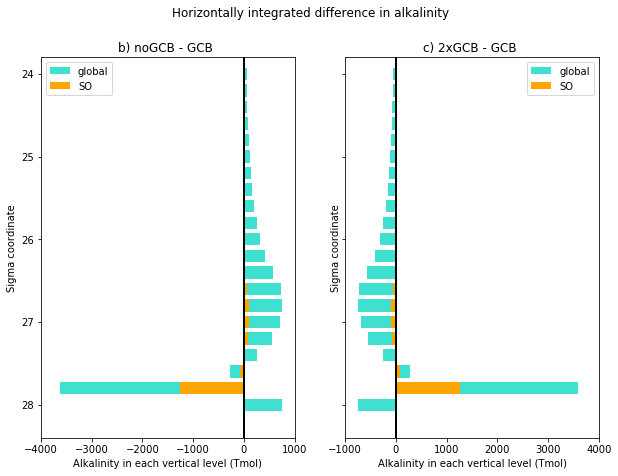

In [51]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,7),sharey='row')

fig.suptitle('Horizontally integrated difference in alkalinity')

ax[0].barh(sigmas, alk_diff,color='turquoise',label='global',height=0.15)
ax[0].barh(sigmas, alk_diff_so,color='orange',label='SO',height=0.15)
ax[0].set_ylabel('Sigma coordinate')
ax[0].set_title('b) noGCB - GCB ')
ax[0].set_xlabel('Alkalinity in each vertical level (Tmol)')
ax[0].axvline(linewidth=2, color='black')
ax[0].set_xlim([-4000,1000])
ax[0].set_ylim([23.8,28.4])
ax[0].invert_yaxis()  # labels read top-to-bottom
ax[0].legend()

ax[1].barh(sigmas, alk_diff2x,color='turquoise',label='global',height=0.15)
ax[1].barh(sigmas, alk_diff_so2x,color='orange',label='SO',height=0.15)
ax[1].set_ylabel('Sigma coordinate')
ax[1].set_title('c) 2xGCB - GCB ')
ax[1].set_xlabel('Alkalinity in each vertical level (Tmol)')
ax[1].axvline(linewidth=2, color='black')
ax[1].set_xlim([-1000,4000])
ax[1].set_ylim([23.8,28.4])
ax[1].invert_yaxis()  # labels read top-to-bottom
ax[1].legend()